Saved: C:\Users\MeaganBrown\Documents\GitHub\figures\groundwater_depth_map_SLR_0.png
Saved: C:\Users\MeaganBrown\Documents\GitHub\figures\groundwater_depth_map_SLR_108.png
Saved: C:\Users\MeaganBrown\Documents\GitHub\figures\groundwater_depth_map_SLR_12.png
Saved: C:\Users\MeaganBrown\Documents\GitHub\figures\groundwater_depth_map_SLR_24.png
Saved: C:\Users\MeaganBrown\Documents\GitHub\figures\groundwater_depth_map_SLR_36.png
Saved: C:\Users\MeaganBrown\Documents\GitHub\figures\groundwater_depth_map_SLR_48.png



KeyboardInterrupt



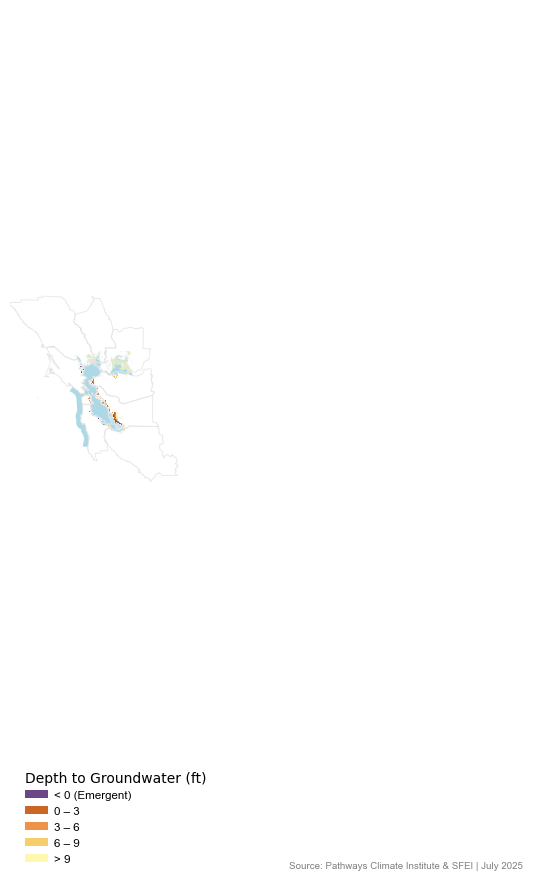

In [3]:
import os
import glob
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from rasterio.enums import Resampling
from rasterio.plot import show

# Set a clean font
plt.rcParams.update({'font.family': 'Arial'})

current_directory = os.getcwd()
# -----------------------------
# File Paths
# -----------------------------
data_dir = os.path.join(os.path.dirname(current_directory), "Pathways_CCA5", "data")
figures_dir = os.path.join(os.path.dirname(current_directory), "Pathways_CCA5", "figures")
os.makedirs(figures_dir, exist_ok=True)  # Create if figures folder doesn't exist

tif_files = glob.glob(os.path.join(data_dir, "PathwaysBayAreaGWMerged", "GW_DTW_SLR_*.tif"))
baylands_path = os.path.join(data_dir, "baylands.shp")
boundary_path = os.path.join(data_dir, "sfbaycounties.shp")
wetlands_path = os.path.join(data_dir, "wetlands.shp")

# -----------------------------
# Load Vector Data (only once)
# -----------------------------
baylands_raw = gpd.read_file(baylands_path)
boundary_raw = gpd.read_file(boundary_path)
wetlands_raw = gpd.read_file(wetlands_path)

# Assign default CRS if missing
for gdf in [baylands_raw, boundary_raw, wetlands_raw]:
    if gdf.crs is None or str(gdf.crs).strip() == "":
        gdf.set_crs(epsg=3310, inplace=True, allow_override=True)

# -----------------------------
# Loop through rasters
# -----------------------------
for tif_path in tif_files:
    with rasterio.open(tif_path) as src:
        raster_crs = src.crs

    # Copy and reproject vector data for this raster
    baylands = baylands_raw.copy()
    boundary = boundary_raw.copy()
    wetlands = wetlands_raw.copy()

    for gdf_name, gdf in [('baylands', baylands), ('boundary', boundary), ('wetlands', wetlands)]:
            if gdf_name == 'baylands': baylands = gdf
            if gdf_name == 'boundary': boundary = gdf
            if gdf_name == 'wetlands': wetlands = gdf

    # Load and process raster
    with rasterio.open(tif_path) as src:
        scale = 0.02
        out_shape = (int(src.height * scale), int(src.width * scale))
        data = src.read(1, out_shape=out_shape, resampling=Resampling.average).astype("float32")
        nodata = src.nodata
        if nodata is not None:
            data[data == nodata] = np.nan
        transform = src.transform * src.transform.scale(src.width / out_shape[1], src.height / out_shape[0])

    # Reclassify
    reclassed = np.full(data.shape, np.nan)
    reclassed[data < 0] = 0
    reclassed[(data >= 0) & (data < 3)] = 1
    reclassed[(data >= 3) & (data < 6)] = 2
    reclassed[(data >= 6) & (data < 9)] = 3
    reclassed[data >= 9] = 4

    labels = ['< 0 (Emergent)', '0 – 3', '3 – 6', '6 – 9', '> 9']
    colors = ['#6A4686', '#CA6726', '#EE924B', '#F6CE6B', '#FFF9B0']
    legend_handles = [Patch(facecolor=col, edgecolor='none', label=lab) for col, lab in zip(colors, labels)]
    norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], len(colors))

    # Extract SLR scenario from filename
    slr_label = os.path.basename(tif_path).split("_")[-1].replace(".tif", "")

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 9))
    show(reclassed, transform=transform, ax=ax, cmap=ListedColormap(colors), norm=norm)
    
    wetlands.plot(ax=ax, facecolor='#E4EDC2', edgecolor='none', linewidth=0.3)
    baylands.plot(ax=ax, facecolor='lightblue', edgecolor='none', linewidth=0.5)
    boundary.plot(ax=ax, facecolor='none', edgecolor='#e5e5e5', linewidth=0.6, alpha=0.9)

    xmin, ymin, xmax, ymax = baylands.total_bounds
    ax.set_xlim(xmin - 1000, xmax + 1000)
    ax.set_ylim(ymin - 1000, ymax + 1000)

    leg = ax.legend(
        handles=legend_handles,
        title="Depth to Groundwater (ft)",
        title_fontsize='medium',
        fontsize='small',
        loc='lower left',
        frameon=False,
        handletextpad=0.5,
        borderpad=0.8,
        labelspacing=0.5
    )
    
    leg._legend_box.align = "left"
    plt.setp(leg.get_title(), family='sans-serif')

    # ax.set_title(f"Depth to GW with {slr_label} inches of SLR", fontsize=14, pad=15)
    ax.axis('off')

    ax.text(0.99, 0.01, "Source: Pathways Climate Institute & SFEI | July 2025", transform=ax.transAxes,
            fontsize=7, ha='right', va='bottom', color='gray')

    plt.tight_layout()
    out_file = os.path.join(figures_dir, f"groundwater_depth_map_SLR_{slr_label}.png")
    plt.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved: {out_file}")

